# Imports

In [1]:
import pandas as pd
import collections
import sys, os, importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from pandas import DataFrame, concat

from sklearn.model_selection import train_test_split, learning_curve, TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Classifier Libraries
from sklearn.linear_model import LogisticRegression

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier

#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_rows', 100)

if os.path.join('..','0_funcoes_base') not in sys.path:
    sys.path.append(os.path.join('..','0_funcoes_base')) 

date_manipulator = importlib.import_module('date_manipulator')
df_manipulator = importlib.import_module('df_manipulator')
plot_manipulator = importlib.import_module('plot_manipulator')
file_manipulator = importlib.import_module('file_manipulator')


# Dados de configuração


In [2]:
input_config = {
    'file': {
        'ref_dir':'../1_pre_processamento/out/',
        'filename':'4_export_lunar_20200517_20200620.csv',
        'delimiter': ';'
    },
    'regions':[0,1]
}

output_config = {
    'file': {
        'ref_dir': './out',
        'prefix':'0_lr_'
    },
    'save_figures': False,
    #'selected_columns':['y-norm','z-norm','z-mean_5', 'z-std_5', 'z-diff_10','y-corr-z-mean_5','z-corr-std_5', 'cp-norm', 'region_id','region_1_distance', 'region_1_counter'],
    #'min_distance_region_1': 10*30,
    'selected_columns':['z-norm','z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id','region_1_distance', 'region_1_counter'],
    'n_chunks': 10,
    'threshold_to_be_region_1': 0.1

}

# Funções

In [96]:
def range2(start,end,step):
    i = start
    while i < end:
        yield i
        i += step
    yield end

def transform_to_supervised(df, previous_steps=1, forecast_steps=1, dropnan=True):

    """
    Transforms a DataFrame containing time series data into a DataFrame
    containing data suitable for use as a supervised learning problem.
    
    Derived from code originally found at 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    :param df: pandas DataFrame object containing columns of time series values
    :param previous_steps: the number of previous steps that will be included in the
                           output DataFrame corresponding to each input column
    :param forecast_steps: the number of forecast steps that will be included in the
                           output DataFrame corresponding to each input column
    :return Pandas DataFrame containing original columns, renamed <orig_name>(t), as well as
            columns for previous steps, <orig_name>(t-1) ... <orig_name>(t-n) and columns 
            for forecast steps, <orig_name>(t+1) ... <orig_name>(t+n)
    """
    
    # original column names
    col_names = df.columns
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


def undersample_majoritory_class(df, target_column, bounds, extra_values=None):
    region_1_initial_timestamps = df.loc[(df[target_column] == 0) & (df[target_column] != df[target_column].shift(-1))].index

    min_idx = df.index.min()
    max_idx = df.index.max()

    timestamps = []

    for ts in region_1_initial_timestamps:
        start_date = ts - pd.Timedelta(seconds=bounds[0])
        end_date = ts + pd.Timedelta(seconds=bounds[1])
        timestamps.extend(date_manipulator.get_date_window(start_date, end_date, bound=(min_idx, max_idx), to_pydatetime=False))

    if not extra_values:
        undersample_df = df[(df.index.isin(timestamps)) | df[target_column] == 1]
    else:
        undersample_df = df[(df.index.isin(extra_values)) | df[target_column] == 1] #list(map(lambda x: x[0].tolist(), extra_values)))

    return undersample_df


def undersample_majoritory_class_v2(df, target_column, start_events):
    min_idx = df.index.min()
    max_idx = df.index.max()

    timestamps = []

    for ts in region_1_initial_timestamps:
        start_date = ts - pd.Timedelta(seconds=bounds[0])
        end_date = ts + pd.Timedelta(seconds=bounds[1])
        timestamps.extend(date_manipulator.get_date_window(start_date, end_date, bound=(min_idx, max_idx), to_pydatetime=False))

    if not extra_values:
        undersample_df = df[(df.index.isin(timestamps)) | df[target_column] == 1]
    else:
        undersample_df = df[(df.index.isin(extra_values)) | df[target_column] == 1] #list(map(lambda x: x[0].tolist(), extra_values)))

    return undersample_df


def count_plot(df, column, title, palette=["#7159C1", "#DF0101"], figsize=(12,6), fontsize=18):
    fig, ax = plt.subplots(1, 1, figsize=figsize)   
    sns.countplot(column, data=df, palette=["#7159C1", "#DF0101"])
    plt.title(title, fontsize=fontsize)
    ax.set_ylabel('')

# Carrega o dataframe

In [5]:
df = df_manipulator.load_dataframes(input_config['file']['filename'], input_config['file']['ref_dir'], input_config['file']['delimiter'])
df.timestamp = pd.to_datetime(df.timestamp)
df_manipulator.set_index(df, 'timestamp', True)
df.sort_index(inplace=True)

# Seleciona colunas de interesse

In [10]:
df = df[output_config['selected_columns']]

df

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.552776,0.321214,0.048423,0.843891,-0.532826,0,50,0
2020-05-17 20:14:37.900,-0.041714,0.323497,0.045659,0.841856,-0.540776,0,51,0
2020-05-17 20:14:38.000,0.272090,0.325989,0.059910,0.602351,-0.540776,0,52,0
2020-05-17 20:14:38.100,0.272090,0.316689,0.070821,0.222601,-0.540776,0,53,0
2020-05-17 20:14:38.200,-0.041714,0.322536,0.075456,0.328441,-0.540776,0,54,0
...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.208149,0.636722,0.116481,-0.169956,0.728129,0,69,0
2020-06-20 14:41:23.900,2.208149,0.567091,0.171353,0.258179,0.856780,0,70,0
2020-06-20 14:41:24.000,1.664034,0.447201,0.219316,-0.059432,0.944450,0,71,0


# Substitui +inf, -inf values por valores com ffill

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)

df

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.552776,0.321214,0.048423,0.843891,-0.532826,0,50,0
2020-05-17 20:14:37.900,-0.041714,0.323497,0.045659,0.841856,-0.540776,0,51,0
2020-05-17 20:14:38.000,0.272090,0.325989,0.059910,0.602351,-0.540776,0,52,0
2020-05-17 20:14:38.100,0.272090,0.316689,0.070821,0.222601,-0.540776,0,53,0
2020-05-17 20:14:38.200,-0.041714,0.322536,0.075456,0.328441,-0.540776,0,54,0
...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.208149,0.636722,0.116481,-0.169956,0.728129,0,69,0
2020-06-20 14:41:23.900,2.208149,0.567091,0.171353,0.258179,0.856780,0,70,0
2020-06-20 14:41:24.000,1.664034,0.447201,0.219316,-0.059432,0.944450,0,71,0


# Transforma série temporal em dados supervisionados

In [15]:
#ignored_columns = ['z-mean_5', 'z-std_5', 'z-diff_10','y-corr-z-mean_5','z-corr-std_5', 'region_id', 'cp-norm', 'region_1_distance', 'region_1_counter']
ignored_columns = ['z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id', 'region_1_distance', 'region_1_counter']

df_supervised = transform_to_supervised(df, previous_steps=5, forecast_steps=1)

ignored_columns_aux = []
for ic in ignored_columns:
    for col in df_supervised.columns.values:
        if ic in col and '(t)' not in col:
            ignored_columns_aux.append(col)

df_supervised.drop(list(set(ignored_columns_aux)), axis=1, inplace=True)

df_supervised

,z-norm(t-5),z-norm(t-4),z-norm(t-3),z-norm(t-2),z-norm(t-1),z-norm(t),z-std_10(t),z-mean_50(t),z-corr-std_5(t),cp-norm(t),region_id(t),region_1_distance(t),region_1_counter(t)
timestamp,,,,,,,,,,,,,
2020-05-17 20:14:38.300,0.552776,-0.041714,0.272090,0.272090,-0.041714,0.486568,0.312848,0.089361,-0.484383,-0.540776,0,55,0
2020-05-17 20:14:38.400,-0.041714,0.272090,0.272090,-0.041714,0.486568,0.486568,0.313175,0.096386,-0.289148,-0.540776,0,56,0
2020-05-17 20:14:38.500,0.272090,0.272090,-0.041714,0.486568,0.486568,0.336858,0.276302,0.100416,-0.776487,-0.540776,0,57,0
2020-05-17 20:14:38.600,0.272090,-0.041714,0.486568,0.486568,0.336858,0.780216,0.262756,0.110061,0.387222,-0.519671,0,58,0
2020-05-17 20:14:38.700,-0.041714,0.486568,0.486568,0.336858,0.780216,0.780216,0.289260,0.125233,0.387903,-0.498566,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-20 14:41:23.800,2.648618,2.295953,2.295953,2.596794,2.544980,2.208149,0.636722,0.116481,-0.169956,0.728129,0,69,0
2020-06-20 14:41:23.900,2.295953,2.295953,2.596794,2.544980,2.208149,2.208149,0.567091,0.171353,0.258179,0.856780,0,70,0
2020-06-20 14:41:24.000,2.295953,2.596794,2.544980,2.208149,2.208149,1.664034,0.447201,0.219316,-0.059432,0.944450,0,71,0


# Distribuição de Região no dataframe

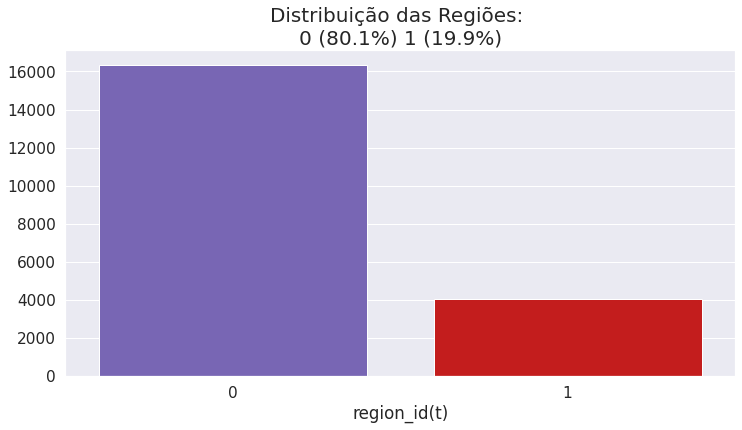

In [97]:
title = 'Distribuição das Regiões: \n' + str(0) + ' (' + str(round(df_supervised['region_id(t)'].value_counts()[0]/len(df_supervised) * 100,1)) + '%' + ') ' + str(1) + ' (' + str(round(df_supervised['region_id(t)'].value_counts()[1]/len(df_supervised) * 100,1)) + '%' + ')'

count_plot(df_supervised, 'region_id(t)', title=title, fontsize=20)

# Adiciona feature para facilitar o split dos dados em chunks balanceados

In [20]:
initial_timestamp_by_speed_bump = df_supervised.sort_values('timestamp').groupby('region_1_counter(t)').head(1).where(df_supervised['region_1_counter(t)'] > 0).dropna()[['region_1_counter(t)']]

initial_timestamp_by_speed_bump = initial_timestamp_by_speed_bump['region_1_counter(t)'].to_dict()


In [22]:
res = np.zeros(len(df_supervised['region_id(t)']))

res[0] = df_supervised['region_id(t)'].iloc[0]

count = 0
i = 0
vals = {}

for idx, val in df_supervised['region_id(t)'].iloc[0:].iteritems():
    vals[i] = val
    
    if val == 0:
        res[i] = count
    elif val == 1:
        if vals[i-1] == 0:
            count += 1
        res[i] = count
    i +=1

df_supervised['region_1_split(t)'] = res.astype(int)
df_supervised['region_1_split(t)'].loc[df_supervised['region_1_split(t)'] < 1] = 1

# Separação de dados para treino e teste respeitando a temporalidade e distribuição proporcional de eventos entre chunks

In [91]:
n_chunks = 6

total_region_1 = df_supervised['region_1_split(t)'][-1]
region_1_per_chunk = int(total_region_1/n_chunks)

print(f'{region_1_per_chunk} eventos por bloco no total de {total_region_1} eventos e {n_chunks} blocos', '\n')
print('\nQuebra-molas nº:')
train_ignore_columns = ['region_id(t)','region_1_distance(t)', 'region_1_counter(t)', 'region_1_split(t)']
target_column = 'region_id(t)'

prev_i = 0
iterations = 0

x_trains, x_tests, y_trains, y_tests = [], [], [], []

for i in range2(region_1_per_chunk, total_region_1, region_1_per_chunk):
    
    df_i = (df_supervised.loc[(df_supervised['region_1_split(t)'] > prev_i) & (df_supervised['region_1_split(t)'] <= i)])

    data_i =  df_i.drop(train_ignore_columns, axis=1).values
    target_i = df_i[target_column].values

    distribution_text = str(0) + ' (' + str(round(df_i['region_id(t)'].value_counts()[0]/len(df_i) * 100,1)) + '%' + ') ' + str(1) + ' (' + str(round(df_i['region_id(t)'].value_counts()[1]/len(df_i) * 100,1)) + '%' + ')'

    print('{:>02d} -> {:>02d} :{:>20s}'.format(prev_i, i, distribution_text))

    if iterations % 2 == 0:
        x_trains.append(data_i)
        y_trains.append(target_i)
    else:
        x_tests.append(data_i)
        y_tests.append(target_i)

    prev_i = i
    iterations += 1


13 eventos por bloco no total de 79 eventos e 6 blocos 


Quebra-molas nº:
00 -> 13 : 0 (84.8%) 1 (15.2%)
13 -> 26 : 0 (75.8%) 1 (24.2%)
26 -> 39 : 0 (74.2%) 1 (25.8%)
39 -> 52 : 0 (80.2%) 1 (19.8%)
52 -> 65 : 0 (83.2%) 1 (16.8%)
65 -> 78 : 0 (78.8%) 1 (21.2%)
78 -> 79 : 0 (58.9%) 1 (41.1%)


# Classificadores para treino

In [84]:
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'liblinear']}
classifiers = {
    "LogisiticRegression LL l1": LogisticRegression(solver='liblinear', penalty='l1'),
    "LogisiticRegression LL l2": LogisticRegression(solver='liblinear', penalty='l2'),
    "LogisiticRegression NG l2": LogisticRegression(solver='newton-cg', penalty='l2')
}

In [85]:
from sklearn.metrics import precision_recall_curve

cms = {}
threshold = output_config['threshold_to_be_region_1']

for i in range (0, len(x_tests)):
    x_train, x_test = x_trains[i], x_tests[i]
    y_train, y_test = y_trains[i], y_tests[i]

    for key, classifier in classifiers.items():
        
        classifier.fit(x_train, y_train)

        y_proba = classifier.predict_proba(x_test)
        y_pred  = classifier.predict(x_test)
        
        #y_p = y_proba
        y_pred_2 = (y_proba[:,1] >= threshold).astype('int')

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred_2, pos_label=1)

        print(f'[{key}] AUC: ', round(metrics.auc(fpr, tpr), 2) * 100, '%')
        print(f'[{key}] AUC2: ', round(metrics.auc(fpr2, tpr2), 2) * 100, '%')

        print('\n')

        if key not in cms:
            cms[key] = []
        cms[key].append({'cm':metrics.confusion_matrix(y_test, y_pred), 'cm_2':metrics.confusion_matrix(y_test, y_pred_2),  'score': round(classifier.score(x_test, y_test), 2), 'report': classification_report(y_test, y_pred),'report_2': classification_report(y_test, y_pred_2)})

        # prob_region_1 = y_proba[:,1]
        # print(max(prob_region_1), min(prob_region_1), (prob_region_1).mean())
        # precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1]) 
        
        # #retrieve probability of being 1(in second column of probs_y)
        # #pr_auc = metrics.auc(recall, precision)

        # plt.title("Recall vs Threshold")
        # #plt.plot(thresholds, precision[: -1], "b--", label="Precision")
        # plt.plot(thresholds, recall[: -1], "r--", label="Recall")
        # plt.ylabel("Recall")
        # plt.xlabel("Threshold")
        # plt.legend(loc="lower left")
        # plt.ylim([0,1])


[LogisiticRegression L1] AUC:  72.0 %
[LogisiticRegression L1] AUC2:  80.0 %


[LogisiticRegression L2] AUC:  72.0 %
[LogisiticRegression L2] AUC2:  80.0 %


[LogisiticRegression NG L2] AUC:  72.0 %
[LogisiticRegression NG L2] AUC2:  80.0 %


[LogisiticRegression L1] AUC:  79.0 %
[LogisiticRegression L1] AUC2:  80.0 %


[LogisiticRegression L2] AUC:  79.0 %
[LogisiticRegression L2] AUC2:  80.0 %


[LogisiticRegression NG L2] AUC:  79.0 %
[LogisiticRegression NG L2] AUC2:  80.0 %


[LogisiticRegression L1] AUC:  73.0 %
[LogisiticRegression L1] AUC2:  83.0 %


[LogisiticRegression L2] AUC:  73.0 %
[LogisiticRegression L2] AUC2:  83.0 %


[LogisiticRegression NG L2] AUC:  73.0 %
[LogisiticRegression NG L2] AUC2:  83.0 %





LogisiticRegression L1
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      2147
           1       0.62      0.74      0.67       687

    accuracy                           0.82      2834
   macro avg       0.76      0.80      0.78      2834
weighted avg       0.84      0.82      0.83      2834
 



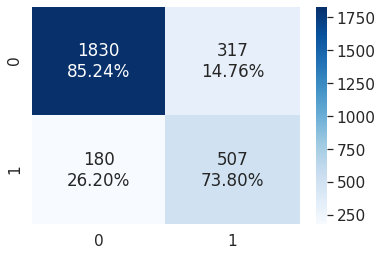


LogisiticRegression L1
               precision    recall  f1-score   support

           0       0.98      0.65      0.78      2693
           1       0.40      0.95      0.57       664

    accuracy                           0.71      3357
   macro avg       0.69      0.80      0.68      3357
weighted avg       0.87      0.71      0.74      3357
 



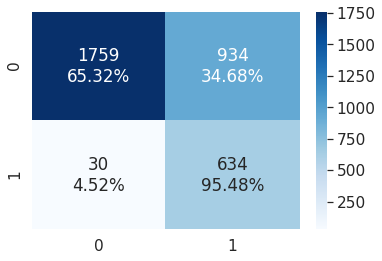


LogisiticRegression L1
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      2469
           1       0.57      0.84      0.68       664

    accuracy                           0.83      3133
   macro avg       0.76      0.83      0.78      3133
weighted avg       0.87      0.83      0.84      3133
 



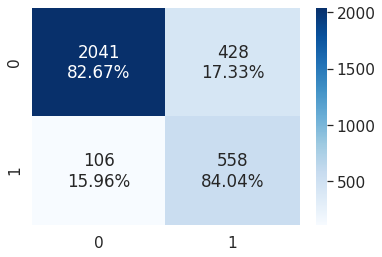


LogisiticRegression L2
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      2147
           1       0.61      0.75      0.67       687

    accuracy                           0.82      2834
   macro avg       0.76      0.80      0.78      2834
weighted avg       0.84      0.82      0.83      2834
 



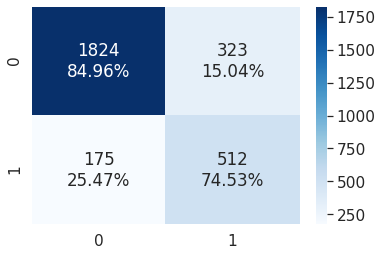


LogisiticRegression L2
               precision    recall  f1-score   support

           0       0.98      0.65      0.78      2693
           1       0.40      0.96      0.57       664

    accuracy                           0.71      3357
   macro avg       0.69      0.80      0.67      3357
weighted avg       0.87      0.71      0.74      3357
 



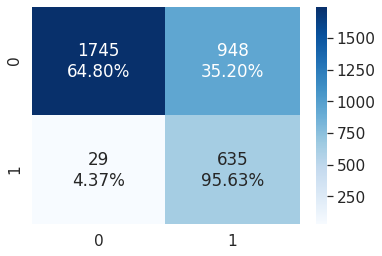


LogisiticRegression L2
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      2469
           1       0.56      0.84      0.67       664

    accuracy                           0.83      3133
   macro avg       0.76      0.83      0.78      3133
weighted avg       0.87      0.83      0.84      3133
 



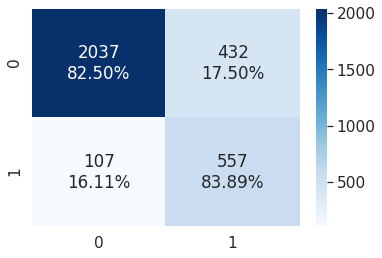


LogisiticRegression NG L2
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      2147
           1       0.62      0.74      0.67       687

    accuracy                           0.83      2834
   macro avg       0.76      0.80      0.78      2834
weighted avg       0.84      0.83      0.83      2834
 



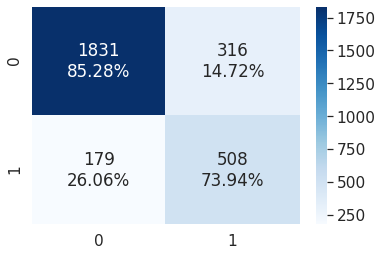


LogisiticRegression NG L2
               precision    recall  f1-score   support

           0       0.98      0.65      0.78      2693
           1       0.40      0.95      0.57       664

    accuracy                           0.71      3357
   macro avg       0.69      0.80      0.68      3357
weighted avg       0.87      0.71      0.74      3357
 



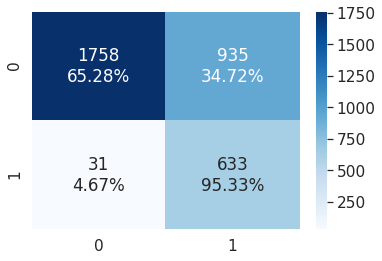


LogisiticRegression NG L2
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      2469
           1       0.56      0.84      0.68       664

    accuracy                           0.83      3133
   macro avg       0.76      0.83      0.78      3133
weighted avg       0.87      0.83      0.84      3133
 



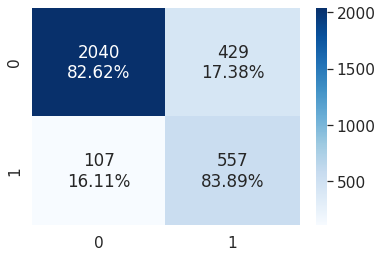

In [86]:
sns.set(font_scale=1.4)

for c in cms:
    for item in cms[c]:
        
        print(f'\n{c}\n', item['report_2'], '\n')
        #group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in  item['cm_2'].flatten()]

        group_percentages = []
        f_item = item['cm_2'].flatten()
        for i in range(0, item['cm_2'].shape[0]):
            for y in range(0, item['cm_2'].shape[1]):
                group_percentages.append("{0:.2%}".format(item['cm_2'][i][y]/np.sum(item['cm_2'][i])))

        labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        sns.heatmap(item['cm_2'], annot=labels, fmt='', cmap='Blues')
        plt.show()


In [73]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
#     """Generate a simple plot of the test and training learning curve"""
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt

In [88]:
custom_cv = zip(x_trains, x_tests)

data   =  df_supervised.drop(train_ignore_columns, axis=1).values
target = df_supervised[target_column].values

#kfold = TimeSeriesSplit(n_splits=5)

# Logistic Regression 
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'liblinear']}


# grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=custom_cv)
# grid_log_reg.fit(data, target)
# log_reg = grid_log_reg.best_estimator_

# knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
# grid_knears.fit(x_train, y_train)
# # KNears best estimator
# knears_neighbors = grid_knears.best_estimator_

# # Support Vector Classifier
# svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
# grid_svc = GridSearchCV(SVC(), svc_params)
# grid_svc.fit(x_train, y_train)

# # SVC best estimator
# svc = grid_svc.best_estimator_

# # DecisionTree Classifier
# tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
#               "min_samples_leaf": list(range(5,7,1))}
# grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
# grid_tree.fit(x_train, y_train)

# # tree best estimator
# tree_clf = grid_tree.best_estimator_

# g = plot_learning_curve(log_reg,"LogisticRegression curves",data,target,cv=kfold)

In [89]:
# log_reg_score = cross_val_score(log_reg, x_train, y_train, cv=5)
# print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

# knears_score = cross_val_score(knears_neighbors, x_train, y_train, cv=5)
# print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

# svc_score = cross_val_score(svc, x_train, y_train, cv=5)
# print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

# tree_score = cross_val_score(tree_clf, x_train, y_train, cv=5)
# print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

In [90]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
# fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()